### Predição da Safra de 2020 | SciCrop

<br>

Neste Notebook será utilizado Machine Learning, mais especificamente Classificação* para prever o dano na safra de 2020 baseados nas informações abaixo:

<br><br>

*Foi escolhido a Classificação porque o resultado a ser previsto é categórico (1,2,3) e não quantitativo, como por exemplo, o número de insetos.

<br>

| Variável                 | Descrição                                                    |
| ------------------------ | ------------------------------------------------------------ |
| Identificador_Agricultor | IDENTIFICADOR DO CLIENTE                                     |
| Estimativa_de_Insetos    | Estimativa de insetos por M²                                 |
| Tipo_de_Cultivo          | Classificação do tipo de cultivo (0,1)                       |
| Tipo_de_Solo             | Classificação do tipo de solo (0,1)                          |
| Categoria_Pesticida      | Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando) |
| Doses_Semana             | Número de doses por semana                                   |
| Semanas_Utilizando       | Número de semanas Utilizada                                  |
| Semanas_Sem_Uso          | Número de semanas sem utilizar                               |
| Temporada                | Temporada Climática (1,2,3)                                  |
| dano_na_plantacao        | Variável de Predição - Dano no Cultivo (0=Sem Danos, 1=Danos causados por outros motivos, 2=Danos gerados pelos pesticidas) |


Este notebook está dividido nas seguintes partes:

<br>
    
    1. Setup do environment
    2. EDA (Exploratory Data Analysis)
    3. Limpando e organizando os dados (caso seja necessário)
    4. Criação do Modelo de Predição
    5. Tunando os Hiperparâmetros
    6. Métricas de Avaliação
    7. Visualizando Category Importance
    8. Visualizando a predição 

### 1. Setup do environment

In [1]:
# Ferramentas básicas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

from scipy import stats

%matplotlib inline

In [ ]:
# Modelos

In [ ]:
# Avalição

In [2]:
# Importando os dados
Safra_18_19 = pd.read_csv('Safra_2018-2019.csv')

# Visualizando a tabela
Safra_18_19.columns

Index(['Unnamed: 0', 'Identificador_Agricultor', 'Estimativa_de_Insetos',
       'Tipo_de_Cultivo', 'Tipo_de_Solo', 'Categoria_Pesticida',
       'Doses_Semana', 'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Temporada',
       'dano_na_plantacao'],
      dtype='object')

### 2. EDA ( Exploratory Data Analysis)

AttributeError: module 'numpy' has no attribute 'mode'

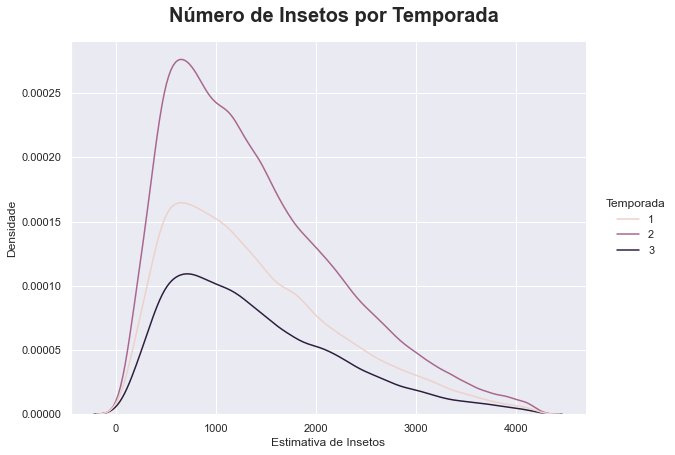

In [43]:
# Visualizando a correlação entre o número de insetos e a estação do ano
sns.set_style('whitegrid')

sns.set(rc={'figure.figsize':(1,20)})

mode = stats.mode(Safra_18_19.Estimativa_de_Insetos)

plot = sns.displot( x       = Safra_18_19.Estimativa_de_Insetos,
                    hue      = Safra_18_19.Temporada, 
                    kind     = 'kde',
                    height   = 6, 
                    aspect   = 11.7/8.27)

plot.fig.suptitle('Número de Insetos por Temporada',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Estimativa de Insetos',
         ylabel = 'Densidade')

plt.axvline(np.mode(xgb_errors),color='b', linestyle='--')
plt.legend({'Moda':mode})

plt.show()

In [ ]:
# Visualizando a correlação entre

### 3. Limpando e organizando os dados (caso seja necessário)

<br>

Seja julgado se é necessário limpar e organizar caso:

<br>

* O dados não estejam organizados.
* Tenha dado faltando.
* Existam dados categóricos.
* Algum dado esteja no formato errado (ex.: `str`, `int`)

In [4]:
Safra_18_19.tail()

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
79995,79995,SCROP79996,209,0,1,2,20,12.0,6,2,0
79996,79996,SCROP79997,232,0,1,2,20,12.0,9,1,0
79997,79997,SCROP79998,256,0,1,2,10,14.0,10,1,0
79998,79998,SCROP79999,256,0,1,2,10,16.0,8,2,0
79999,79999,SCROP80000,256,0,1,2,20,11.0,10,2,0
